In [182]:
import random
import torch
from torch.nn import functional as F
random.seed(0x1337_b00b)

# Context length -> How many characters we take as input for the network to predict
# the next
block_size = 8

class Dataset:
    def __init__(self):
        with open('names.txt', 'r') as f:
            names = f.read().split('\n')
        self.names = names

        self.build_vocab()

        # Shuffle names in place
        random.shuffle(self.names)
        # Training set and dev/validation set last index
        # First 80% is used for training, 10% percent for validation, 10% for test
        train_set_idx = int(0.8 * len(names))
        validation_idx = int(0.9 * len(names))
        
        self.X, self.Y = {}, {}
        self.X["train"], self.Y["train"] = self.build_dataset(self.names[:train_set_idx])
        self.X["valid"], self.Y["valid"] = self.build_dataset(self.names[train_set_idx:validation_idx])
        self.X["test"], self.Y["test"] = self.build_dataset(self.names[validation_idx:])
        

    def build_vocab(self):
        # Build vocabulary
        vocab = []
        for name in self.names:
            vocab += name
        self.vocab = sorted(set(vocab))
        
        # Build mapping from letter to integer id and for id to letter
        # Leave the `0` key for `.` (dot) which new treat as a null / terminating char
        self.itos = { i+1:l for i, l in enumerate(self.vocab)}
        self.itos[0] = '.'
        # Build the inverse mapping -> from character to integer id
        self.stoi = { l:i for i, l in self.itos.items()}
                

    def build_dataset(self, words):
        global block_size
        # Inputs
        X = []
        # Targets
        Y = []
        
        # For each name
        for word in words:
            # The start is an empty new context (which contains our designed dot special character)
            context = [0] * block_size
            # For each character in the name (adding dot as a stopping token)
            for ch in word + '.':
                # We add the current context and as an input to the dataset
                X.append(context)
                # Get the index of the current character and add it as a target for a potential
                # generated new character that could follow this context
                idx_ch = self.stoi[ch]
                Y.append(idx_ch)
                # Slide the context window and add the new character to it
                context = context[1:] + [idx_ch]
    
        X = torch.Tensor(X).long()
        Y = torch.Tensor(Y).long()
        return (X, Y)


    def dataset_demo(self, split, count = 10):
        for i, p in zip(self.X[split][:count], self.Y[split][:count]):
            print(''.join([self.itos[c.item()] for c in i]), "-->", self.itos[p.item()])

In [183]:
d = Dataset()
d.dataset_demo("train", count = 30)

........ --> l
.......l --> a
......la --> t
.....lat --> a
....lata --> s
...latas --> h
..latash --> a
.latasha --> .
........ --> k
.......k --> y
......ky --> n
.....kyn --> s
....kyns --> l
...kynsl --> e
..kynsle --> e
.kynslee --> .
........ --> a
.......a --> b
......ab --> c
.....abc --> d
....abcd --> e
...abcde --> .
........ --> n
.......n --> a
......na --> d
.....nad --> e
....nade --> l
...nadel --> y
..nadely --> n
.nadelyn --> .


In [198]:
# Structuring the code
import torch


torch.manual_seed(42)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        kaimin_scaling = fan_in**0.5
        self.weights = torch.randn((fan_in, fan_out)) / kaimin_scaling
        if bias:
            # Bias initializing with zeros or small floats?
            self.bias = torch.zeros(fan_out)
            # self.bias = torch.rand(fan_out, generator=g) * 0.1
        else:
            self.bias = None


    def __call__(self, x_in):
        self.out = x_in @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out


    def parameters(self):
        params = [self.weights]
        if self.bias is not None:
            params += [self.bias]
        return params


class BatchNorm1d:
    def __init__(self, size, eps=1e-05, momentum=0.1):
        """Batch normalization layers defined accoding to the paper with the same name
        and torch docs

        Args:
            size: size of the batch and implictily this layer
            eps: a small variable to control that we are not dividing by zero
            momentum: The amount that each training iteration affects the final running
                mean and std used in model inference at production time. 
        """
        self.size = size
        # Controls if we are using the running mean and std when inferencing (in prod)
        # or we are computing it from the batch (training)
        self.training = True
        # Training parameters that get updated by the backward pass
        self.gamma = torch.ones(size)
        self.beta = torch.zeros(size)
        # Extra variables used to control the behaviour of the normalisation
        self.eps = eps
        self.momentum = momentum
        # Buffers (torch naming) that are not part of the backward pass and training
        self.running_mean = torch.zeros((1, size))
        self.running_std = torch.ones((1, size))


    def __call__(self, x_in):
        # Compute the mean and the std for the input
        if self.training:
            # No matter the dimensionality of the input, when we are computing normalizations,
            # the actual values we want to normalize are the last channel. As such, we must instruct
            # torch to take the proper dimensions
            
            # If we only have 2 dimensions, we want to reduce along the first dimension 
            if x_in.ndim == 2:
                dim = 0
            # If we have 3 dimensions, we want to reduce along the first 2 dimensions
            elif x_in.ndim == 3:
                dim = (0, 1)
                
            in_mean = x_in.mean(dim, keepdim=True)
            in_std = x_in.std(dim, keepdim=True)
        else:
            in_mean = self.running_mean
            in_std = self.running_std

        # Normalize the layer
        norm = (x_in - in_mean) / torch.sqrt(in_std + self.eps)
        # Compute the batch norm
        self.out = self.gamma * norm + self.beta

        # If we are training, we need to update the running mean and std
        if self.training:
            with torch.no_grad():
                self.running_mean = (1.-self.momentum) * self.running_mean \
                    + self.momentum * in_mean
                self.running_std = (1.-self.momentum) * self.running_std \
                    + self.momentum * in_std
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    
    def parameters(self):
        return []


class Embedding:
    def __init__(self, n_embeddings, emb_size):
        # Create a 2 dimensional embedding vector for the number of embeddings, where each
        # element is represented by an embedding size
        self.weights = torch.randn((n_embeddings, emb_size))


    def __call__(self, IX):
        # Indexing into the embedding vector
        self.out = self.weights[IX]
        return self.out
        

    def parameters(self):
        return [self.weights]


class FlattenConsecutive:
    def __init__(self, n):
        # n represents the amount of elements to be flattened by this layer in the
        # last dimension
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        assert T % self.n == 0
        # Flattens the given input tensor `x`, given the first dimension shape
        x = x.view(B, T // self.n, C * self.n)

        # If the new batch dimension T // self.n is one, we just remove it
        if x.shape[1] == 1:
            x = x.squeeze(1)
            
        self.out = x
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        # A container that calls modules sequentially
        self.layers = layers


    def __call__(self, x):
        self.out = x
        for layer in self.layers:
            self.out = layer(self.out)
        return self.out


    def parameters(self):
        parameters = [p for layer in self.layers for p in layer.parameters()]
        return parameters

In [208]:
vocab_size = 27
emb_size = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, emb_size),
    FlattenConsecutive(2), Linear(emb_size * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # Make last layer less confident by scaling down the weights
    # layers[-1].weights *= 0.1
    # When we have BatchNorm1d as the last layer ,we need to scale the gamma because
    # we do not have weigths, but gamma effectively acts like weights
    seq.layers[-1].weights *= 0.1

parameters = model.parameters()
print("Number of parameters: ", sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

Number of parameters:  76579


In [206]:
# Collect 4 examples of random indexes from the train set
idxs = torch.randint(0, d.X['train'].shape[0], (4,))
Xb, Yb = d.X['train'][idxs], d.Y['train'][idxs]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  8,  1],
        [ 0,  0,  0, 11,  5,  2, 18, 15],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 2,  5, 12, 12,  1, 12, 21, 14]])

In [207]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [203]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [188]:
model.layers[0].out.shape # Embedding layer

torch.Size([4, 8, 10])

In [189]:
model.layers[1].out.shape # Flatten Layer

torch.Size([4, 4, 20])

In [190]:
model.layers[2].out.shape # Linear layer

torch.Size([4, 4, 68])

In [191]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape # Previous

torch.Size([4, 200])

In [192]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape # Grouping as a bigram

torch.Size([4, 4, 200])

In [193]:
e = torch.randn(4, 8, 10)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [209]:
# Optimisation

max_steps = 200000
batch_size = 32
losses = []

for idx in range(max_steps):
    # Minibatch construction
    # Sample indexes from X (minibatc/h of 32 examples)
    idxs = torch.randint(0, d.X["train"].shape[0], (32,))
    
    # Forward pass, only with the minibatch
    x_in = d.X["train"][idxs]
    logits = model(x_in)
    # Compute the loss
    loss = F.cross_entropy(logits, d.Y["train"][idxs])

    # Backward pass
    # Reset the gradients
    for p in parameters:
        p.grad = None
    # Compute the backward pass
    loss.backward()

    # Gradually increase the learning rate in each step
    # lr = lrs[idx]
    lr = 0.1 if idx < 150000 else 0.01
    # Update / nudge the value in the direction of the gradient
    for p in parameters:
        p.data += -lr * p.grad

    # Each 10k steps print the progress of the loss
    if idx % 10000 == 0:
        print(f"{idx:6d} / {max_steps:6d} -> {loss.item():.4f}")
    losses.append(loss.log10().item())

     0 / 200000 -> 3.4617
 10000 / 200000 -> 2.3431
 20000 / 200000 -> 2.0469
 30000 / 200000 -> 1.3418
 40000 / 200000 -> 1.8774
 50000 / 200000 -> 2.0263
 60000 / 200000 -> 1.9282
 70000 / 200000 -> 2.0070
 80000 / 200000 -> 1.7566
 90000 / 200000 -> 1.9436
100000 / 200000 -> 1.7164
110000 / 200000 -> 1.8820
120000 / 200000 -> 2.1821
130000 / 200000 -> 1.7961
140000 / 200000 -> 1.8350
150000 / 200000 -> 1.7098
160000 / 200000 -> 2.0786
170000 / 200000 -> 1.9380
180000 / 200000 -> 1.4729
190000 / 200000 -> 1.4948


In [210]:
import matplotlib.pyplot as plt

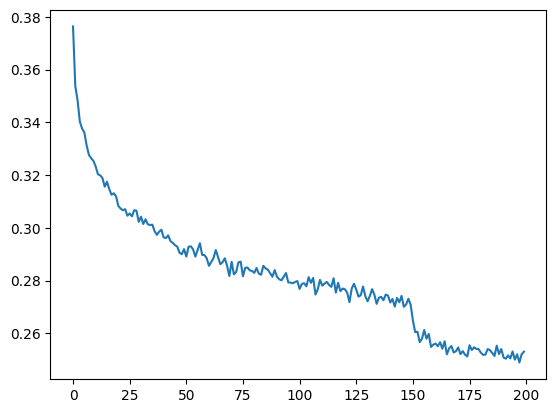

In [211]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [212]:
# Put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [213]:
@torch.no_grad()
def compute_loss(split='train'):
    # Loss over the entire training set
    x = d.X[split]
    logits = model(x)
    # Compute the loss
    loss = F.cross_entropy(logits, d.Y[split])
    
    print(f"{split}, {loss.item()}")

compute_loss()
compute_loss('valid')

train, 1.7612632513046265
valid, 1.9965282678604126


In [83]:
# Sampling from the model

for i in range(20):
    # Storage for the characters
    out = []
    # initial context
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # Sample from the probabilities
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    
    print(''.join([d.itos[o] for o in out]))

traena.
maretchaze.
carric.
mykon.
devanne.
shau.
copen.
maa.
zekaisheney.
viyah.
aubrance.
kyrie.
sharius.
brahmani.
gan.
chreina.
bennalesatareyn.
amonttielynne.
mae.
ogontan.
